### Reqirements
- keras >= 2.2.0 or tensorflow >= 1.13
- segmenation-models==1.0.*
- albumentations==0.3.0

# Loading dataset

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [1]:
import os
from glob import glob

import cv2
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2022-11-18 23:29:31.440137: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-18 23:29:31.559924: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-18 23:29:32.021813: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/cv2/../../lib64::/home/nkspartan/miniconda3/envs/tf-gpu/lib/
2022-11-18 23:29:32.021882: W tensorflow/stream_executor/platform/default/dso_loade

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2022-11-18 23:29:32.959845: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 23:29:32.964213: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 23:29:32.964390: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
DATA_DIR = './dataset/dataset_v3'

In [4]:
x_train_dir = os.path.join(DATA_DIR, 'train/images')
y_train_dir = os.path.join(DATA_DIR, 'train/masks')

x_valid_dir = os.path.join(DATA_DIR, 'validation/images')
y_valid_dir = os.path.join(DATA_DIR, 'validation/masks')

x_test_dir = os.path.join(DATA_DIR, 'test/images')
y_test_dir = os.path.join(DATA_DIR, 'test/masks')

# Dataloader and utility functions 

In [5]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

def cartoonize_image(img):
    # Defining input data for clustering
    data = np.float32(img).reshape((-1, 3))

    # Defining criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)
    # Applying cv2.kmeans function
    _, label, center = cv2.kmeans(data, 8, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    center = np.uint8(center)
    # Reshape the output data to the size of input image
    result = center[label.flatten()]
    result = result.reshape(img.shape)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Perform adaptive threshold
    edges  = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 9, 8)

    blurred = cv2.medianBlur(result, 3)
    # Combine the result and edges to get final cartoon effect
    cartoon = cv2.bitwise_and(blurred, blurred, mask=edges)

    return cartoon

def overlay_edges(img):
    edges = cv2.Canny(img, 90, 120)   # canny edge detector

    img[edges == 255] = [255, 0, 0]  # turn edges to red

    return img

def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
    """Return a sharpened version of the image, using an unsharp mask."""
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

def sharpen_image(image):
    kernel = np.array([[-1,-1,-1], 
                    [-1, 9,-1],
                    [-1,-1,-1]])
    sharpened = cv2.filter2D(image, -1, kernel)

    return sharpened

def denoise_image(image):
    noiseless_image = cv2.bilateralFilter(image, 11, 41, 21)

    return noiseless_image

    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['river', 'not_river']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [str(i) for i in glob(images_dir + '/*')]
        self.masks_fps = [str(i) for i in glob(masks_dir + '/*')]
        self.images_fps.sort()
        self.masks_fps.sort()

        # convert str names to class values on masks
        self.class_values = classes
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (320, 320), interpolation = cv2.INTER_AREA)
        #image = cartoonize_image(image)
        #image = overlay_edges(image)
        #image = unsharp_mask(image)
        #image = sharpen_image(image)
        image = denoise_image(image)

        mask = cv2.imread(self.masks_fps[i])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = cv2.resize(mask, (320, 320), interpolation = cv2.INTER_AREA)
        mask = np.expand_dims(mask, axis=-1)
        mask = mask.astype('float')
        
        # extract certain classes from mask (e.g. cars)
        #masks = [(mask == v) for v in self.class_values]
        #mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

(320, 320, 1)


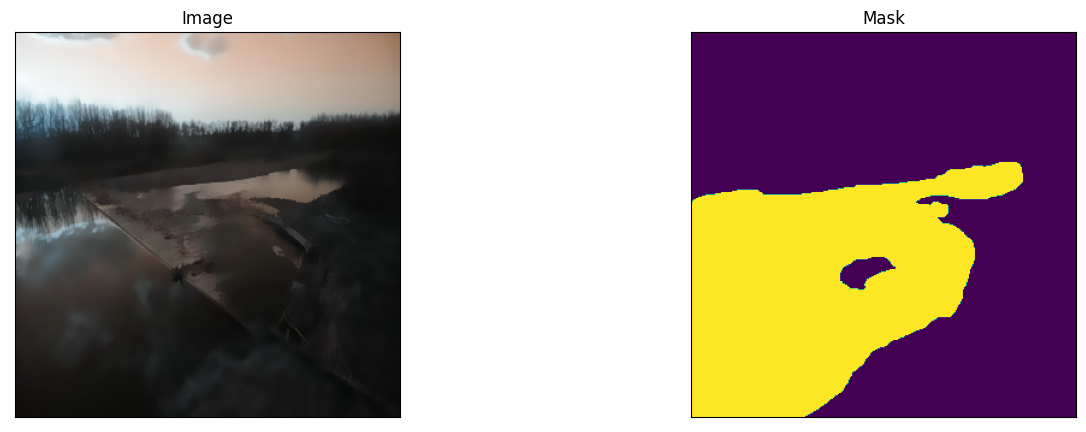

In [6]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=[0, 1])

image, mask = dataset[5] # get some sample
print(mask.shape)
visualize(
    image=image, 
    mask=mask
)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.


In [7]:
import albumentations as A

In [8]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=320, width=320, always_apply=True),

        A.GaussNoise(p=0.2),
        A.Perspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.Sharpen(p=1),
                #A.Blur(blur_limit=3, p=1),
                #A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


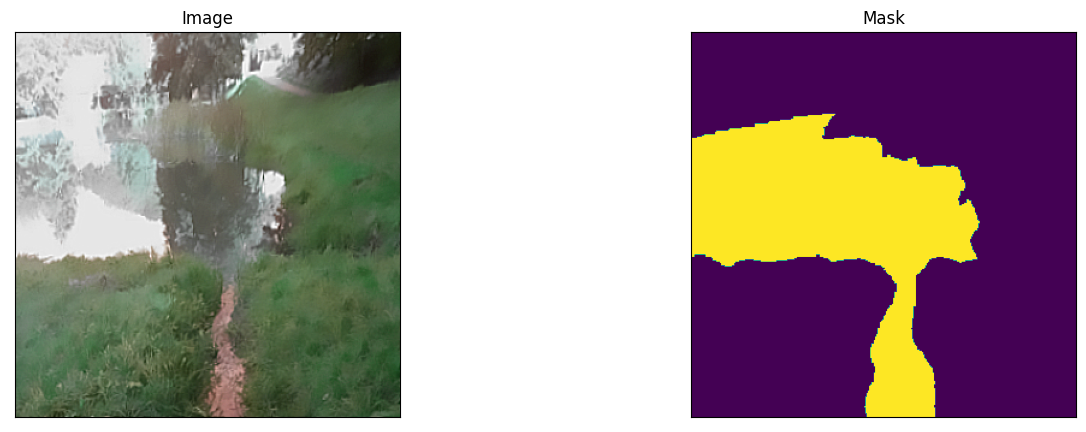

In [9]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=[0, 1], augmentation=get_training_augmentation())

image, mask = dataset[12] # get some sample
visualize(
    image=image, 
    mask=mask
)

# Segmentation model training

In [10]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

Segmentation Models: using `keras` framework.


In [11]:
BACKBONE = 'seresnext50'
BATCH_SIZE = 4
CLASSES = [1]
LR = 0.0001
EPOCHS = 70

preprocess_input = sm.get_preprocessing(BACKBONE)

In [12]:
# define network parameters
n_classes = 1  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

2022-11-18 23:29:33.788550: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-18 23:29:33.789230: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 23:29:33.789467: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 23:29:33.789626: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [13]:
#model.summary()

In [14]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [15]:
import datetime

date_actual = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + date_actual
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=16)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"model_weights/{date_actual}_segmentation_best_weights.hdf5",
                               monitor='val_loss',
                               verbose=1,
                               save_weights_only=True,
                               save_best_only=True)

In [16]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=[0, 1], 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=[0, 1], 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 320, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 320, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    checkpoint_callback,
    es_callback,
    tensorboard_callback,
    keras.callbacks.ReduceLROnPlateau(),
]

In [17]:
# train model
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/70


2022-11-18 23:30:02.689151: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-18 23:30:03.065232: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-18 23:30:03.066223: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-18 23:30:03.066235: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-18 23:30:03.067074: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-18 23:30:03.067126: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-11-18 23:30:03.630914: W tensorflow/core/common_runtime/bf

200/200 [==============================] - ETA: 0s - loss: 0.6454 - iou_score: 0.4822 - f1-score: 0.6281
Epoch 1: val_loss improved from inf to 0.47711, saving model to model_weights/20221118-232939_segmentation_best_weights.hdf5


2022-11-18 23:31:24.812677: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1698693120 exceeds 10% of free system memory.


200/200 [==============================] - 106s 394ms/step - loss: 0.6454 - iou_score: 0.4822 - f1-score: 0.6281 - val_loss: 0.4771 - val_iou_score: 0.6615 - val_f1-score: 0.7749 - lr: 1.0000e-04
Epoch 2/70
200/200 [==============================] - ETA: 0s - loss: 0.4660 - iou_score: 0.6325 - f1-score: 0.7610
Epoch 2: val_loss improved from 0.47711 to 0.42430, saving model to model_weights/20221118-232939_segmentation_best_weights.hdf5


2022-11-18 23:32:40.559362: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1698693120 exceeds 10% of free system memory.


200/200 [==============================] - 76s 378ms/step - loss: 0.4660 - iou_score: 0.6325 - f1-score: 0.7610 - val_loss: 0.4243 - val_iou_score: 0.7050 - val_f1-score: 0.8055 - lr: 1.0000e-04
Epoch 3/70
200/200 [==============================] - ETA: 0s - loss: 0.3642 - iou_score: 0.7076 - f1-score: 0.8191
Epoch 3: val_loss improved from 0.42430 to 0.33977, saving model to model_weights/20221118-232939_segmentation_best_weights.hdf5


2022-11-18 23:33:55.777130: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1698693120 exceeds 10% of free system memory.


200/200 [==============================] - 75s 376ms/step - loss: 0.3642 - iou_score: 0.7076 - f1-score: 0.8191 - val_loss: 0.3398 - val_iou_score: 0.7187 - val_f1-score: 0.8157 - lr: 1.0000e-04
Epoch 4/70
200/200 [==============================] - ETA: 0s - loss: 0.3174 - iou_score: 0.7374 - f1-score: 0.8394
Epoch 4: val_loss improved from 0.33977 to 0.33552, saving model to model_weights/20221118-232939_segmentation_best_weights.hdf5


2022-11-18 23:35:11.560273: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1698693120 exceeds 10% of free system memory.


200/200 [==============================] - 76s 378ms/step - loss: 0.3174 - iou_score: 0.7374 - f1-score: 0.8394 - val_loss: 0.3355 - val_iou_score: 0.7624 - val_f1-score: 0.8494 - lr: 1.0000e-04
Epoch 5/70
200/200 [==============================] - ETA: 0s - loss: 0.2699 - iou_score: 0.7657 - f1-score: 0.8595
Epoch 5: val_loss improved from 0.33552 to 0.29952, saving model to model_weights/20221118-232939_segmentation_best_weights.hdf5


2022-11-18 23:36:26.958164: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1698693120 exceeds 10% of free system memory.


200/200 [==============================] - 75s 376ms/step - loss: 0.2699 - iou_score: 0.7657 - f1-score: 0.8595 - val_loss: 0.2995 - val_iou_score: 0.7618 - val_f1-score: 0.8464 - lr: 1.0000e-04
Epoch 6/70
200/200 [==============================] - ETA: 0s - loss: 0.2155 - iou_score: 0.8129 - f1-score: 0.8918
Epoch 6: val_loss improved from 0.29952 to 0.26369, saving model to model_weights/20221118-232939_segmentation_best_weights.hdf5
200/200 [==============================] - 76s 380ms/step - loss: 0.2155 - iou_score: 0.8129 - f1-score: 0.8918 - val_loss: 0.2637 - val_iou_score: 0.7827 - val_f1-score: 0.8622 - lr: 1.0000e-04
Epoch 7/70
200/200 [==============================] - ETA: 0s - loss: 0.1949 - iou_score: 0.8198 - f1-score: 0.8974
Epoch 7: val_loss did not improve from 0.26369
200/200 [==============================] - 74s 368ms/step - loss: 0.1949 - iou_score: 0.8198 - f1-score: 0.8974 - val_loss: 0.2945 - val_iou_score: 0.7283 - val_f1-score: 0.8237 - lr: 1.0000e-04
Epoch 8

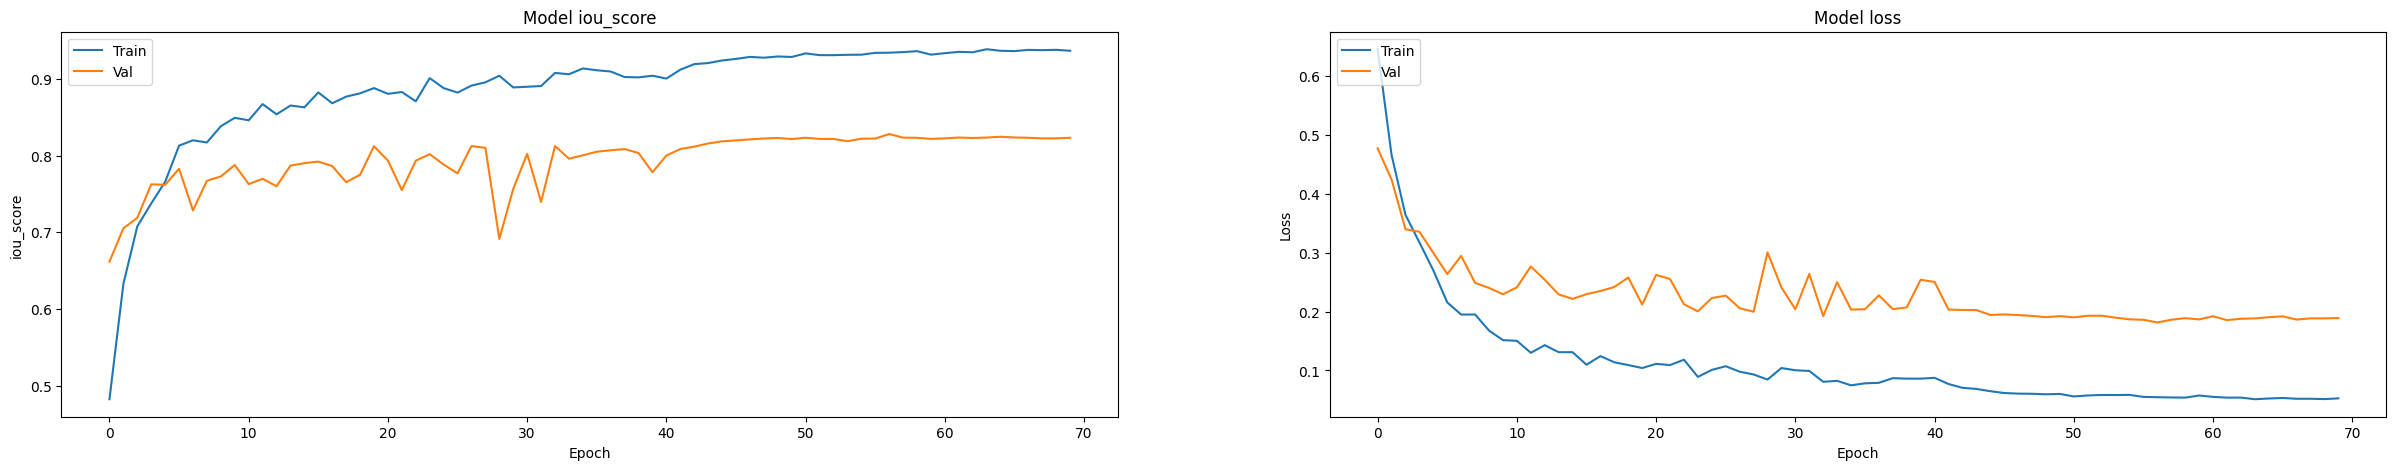

In [18]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Model Evaluation

In [19]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    #augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [20]:
print(date_actual)

20221118-232939


In [21]:
# load best weights
model.load_weights(f'model_weights/{date_actual}_segmentation_best_weights.hdf5')

#model.load_weights("best_model_weights/seg_model_resnet_50_1.hdf5")

In [22]:
scores = model.evaluate(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

111/111 [==============================] - 6s 42ms/step - loss: -74.0869 - iou_score: 0.9106 - f1-score: 0.8272
Loss: -74.087
mean iou_score: 0.9106
mean f1-score: 0.82723


# Visualization of results on test dataset

1/1 [==============================] - 0s 42ms/step


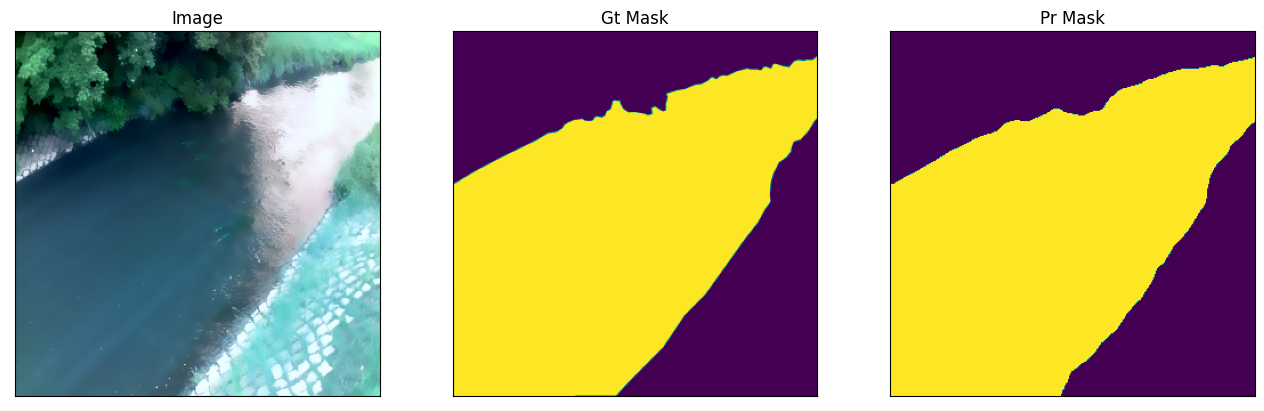

1/1 [==============================] - 0s 45ms/step


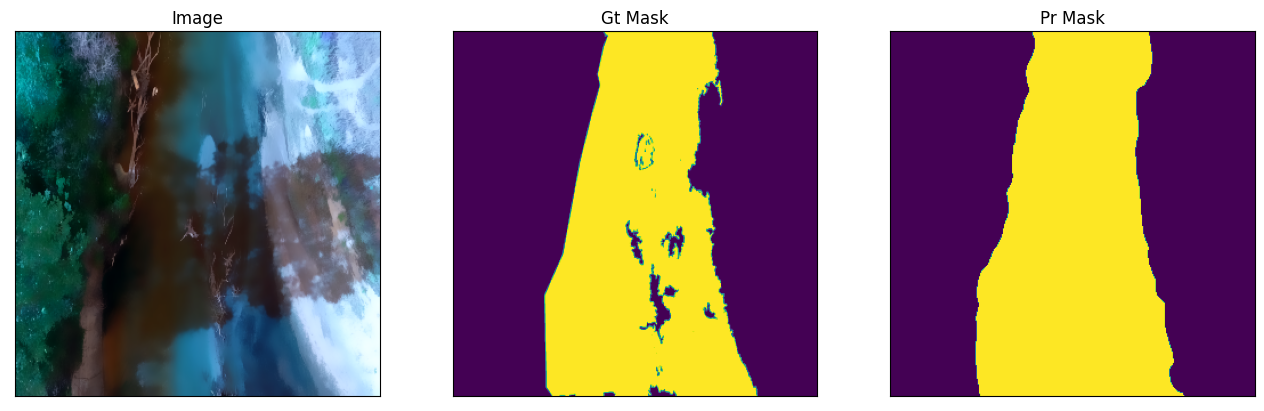

1/1 [==============================] - 0s 42ms/step


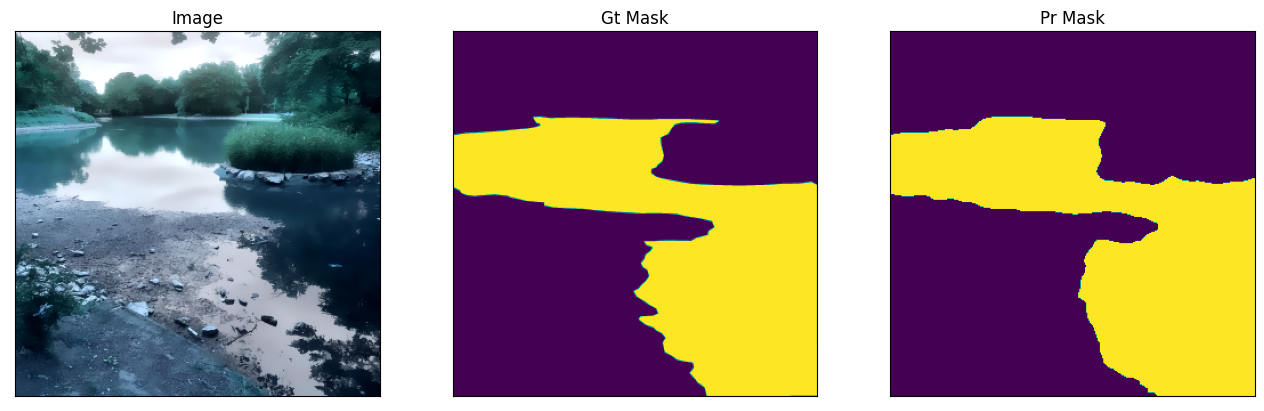

1/1 [==============================] - 0s 42ms/step


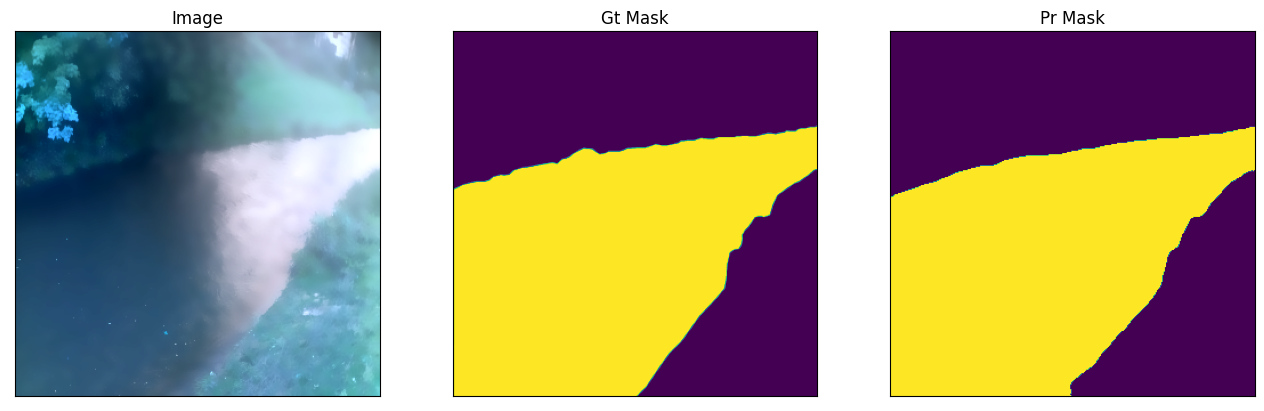

1/1 [==============================] - 0s 41ms/step


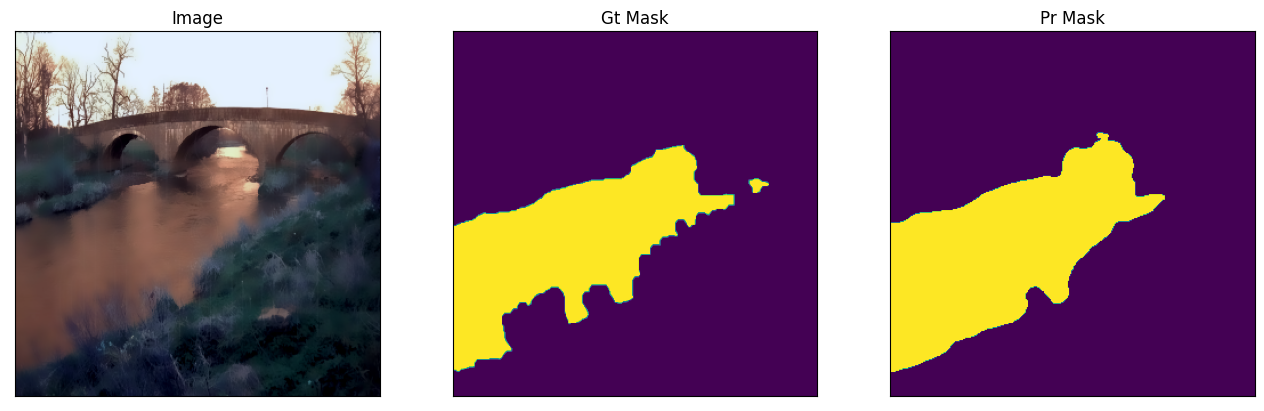

In [28]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask.squeeze(),
        pr_mask=pr_mask.squeeze(),
    )

## Visualize with test dataset of images for hydrology project

In [24]:
# define heavy augmentations
def get_image_fixing():
    train_transform = [
        A.OneOf(
            [
                A.RandomBrightness(limit=0.4, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.Sharpen(alpha=(0.2, 0.3), p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                #A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return A.Compose(train_transform)

In [32]:
test_h_dataset = Dataset(
    "river_segmented_hydrology/images", 
    "river_segmented_hydrology/masks", 
    classes=CLASSES, 
    #augmentation=get_image_fixing(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_h_dataloader = Dataloder(test_h_dataset, batch_size=1, shuffle=False)

1/1 [==============================] - 0s 41ms/step


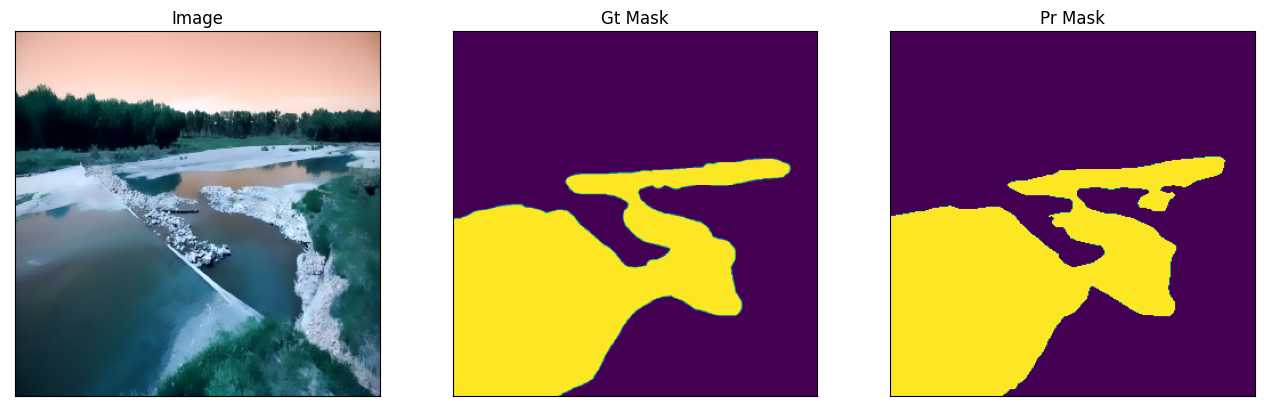

1/1 [==============================] - 0s 43ms/step


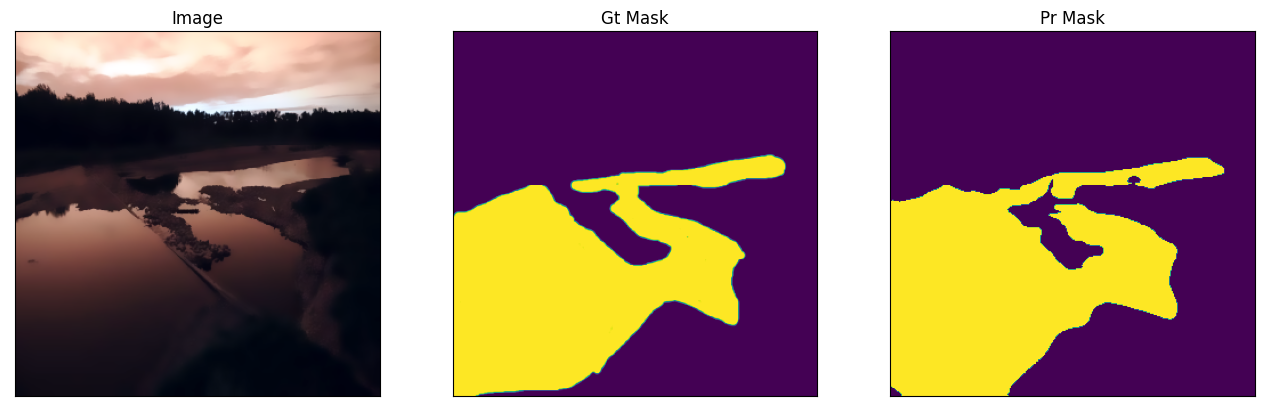

1/1 [==============================] - 0s 42ms/step


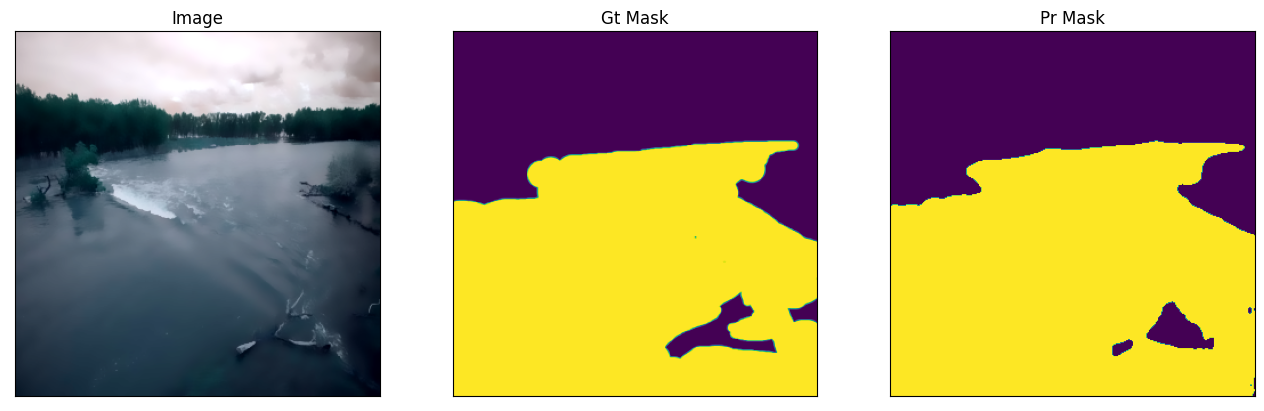

1/1 [==============================] - 0s 40ms/step


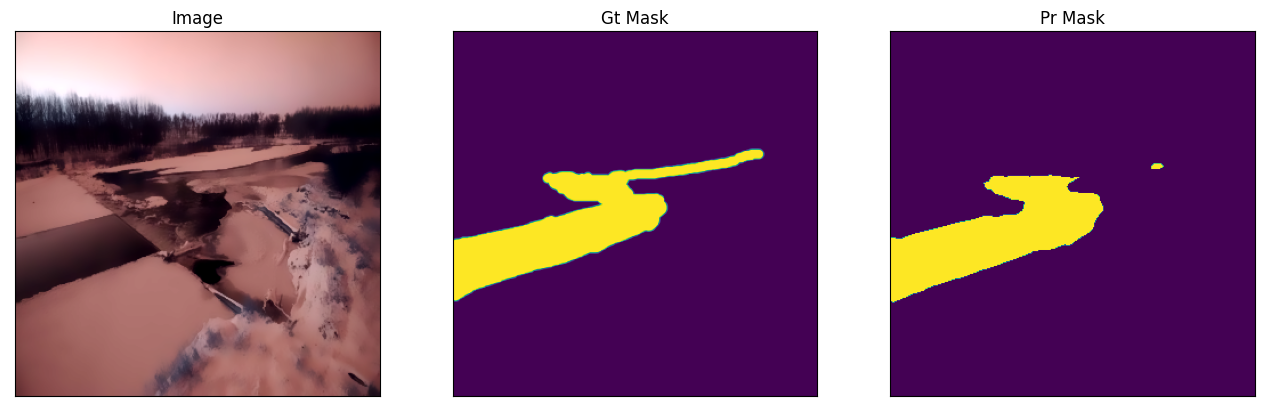

1/1 [==============================] - 0s 40ms/step


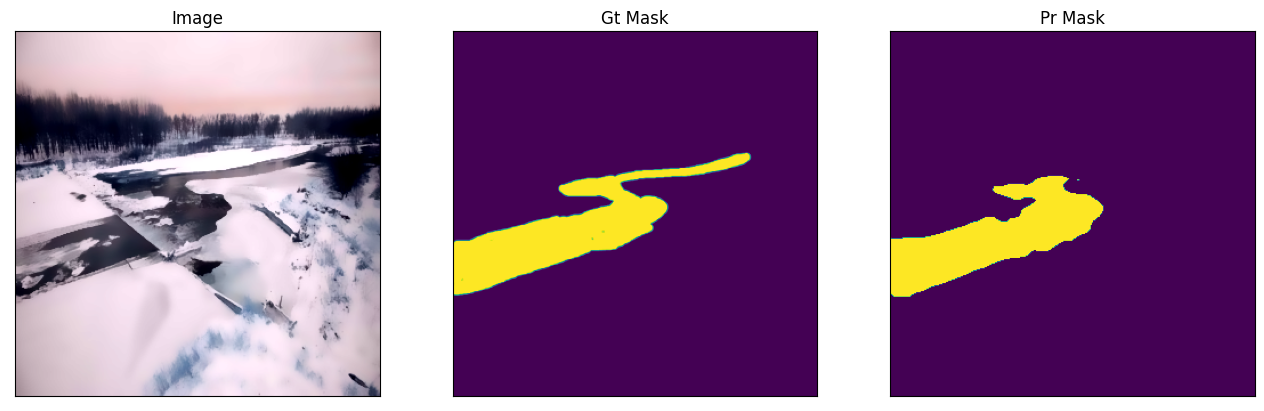

1/1 [==============================] - 0s 44ms/step


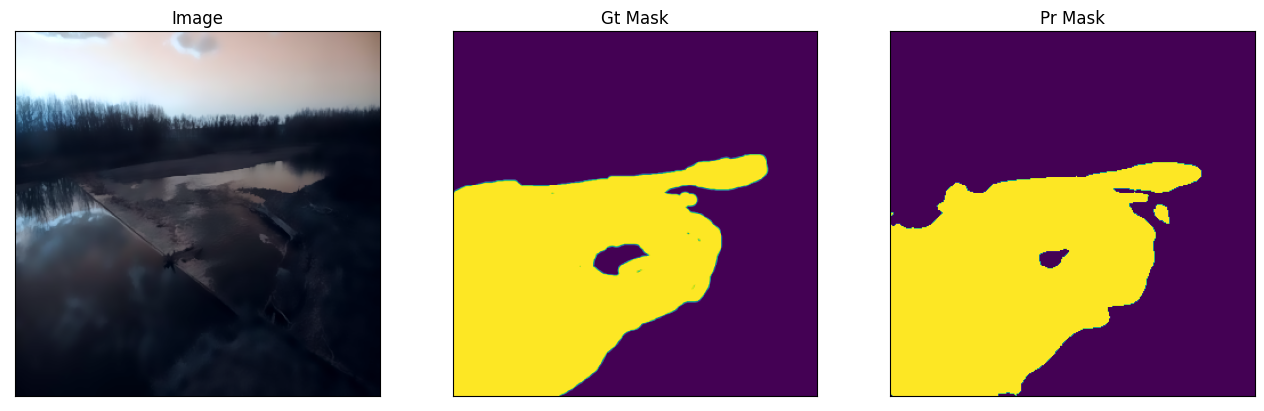

1/1 [==============================] - 0s 41ms/step


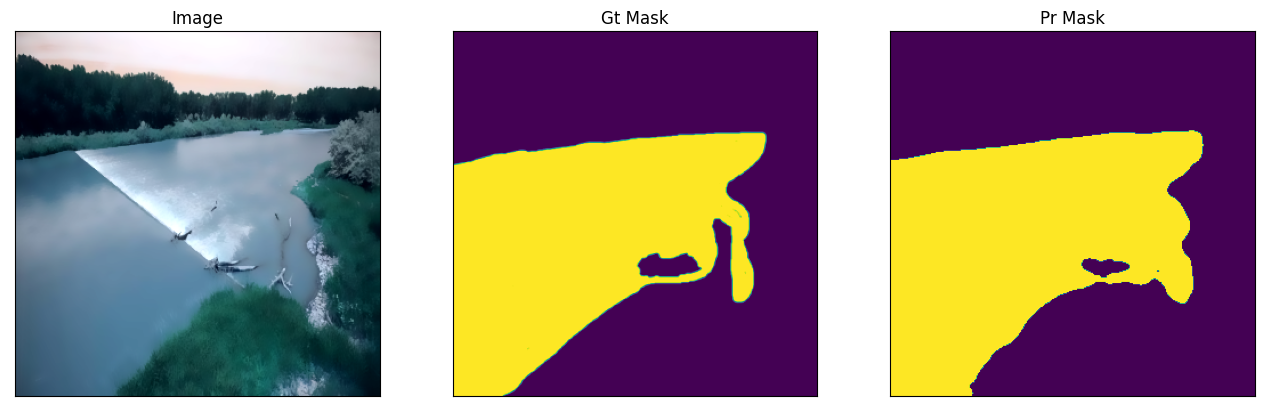

1/1 [==============================] - 0s 39ms/step


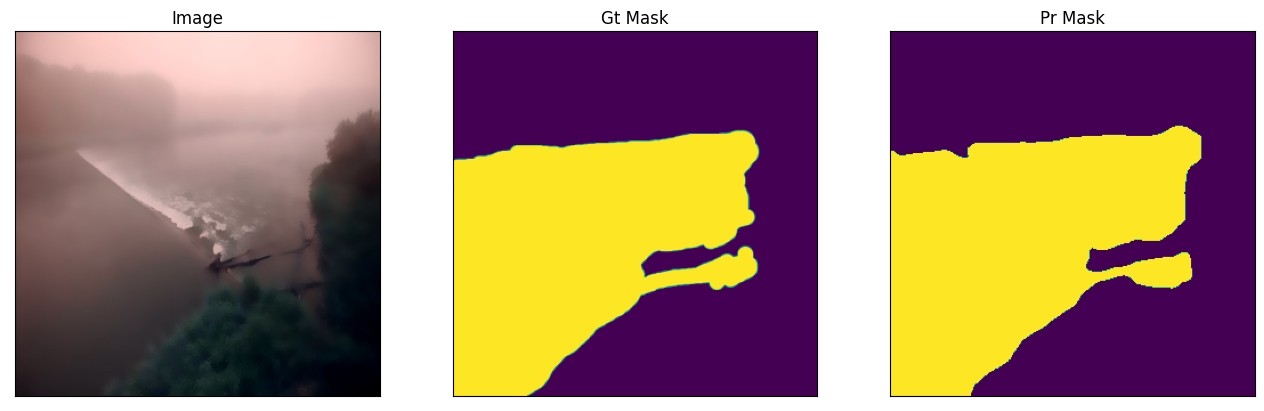

1/1 [==============================] - 0s 40ms/step


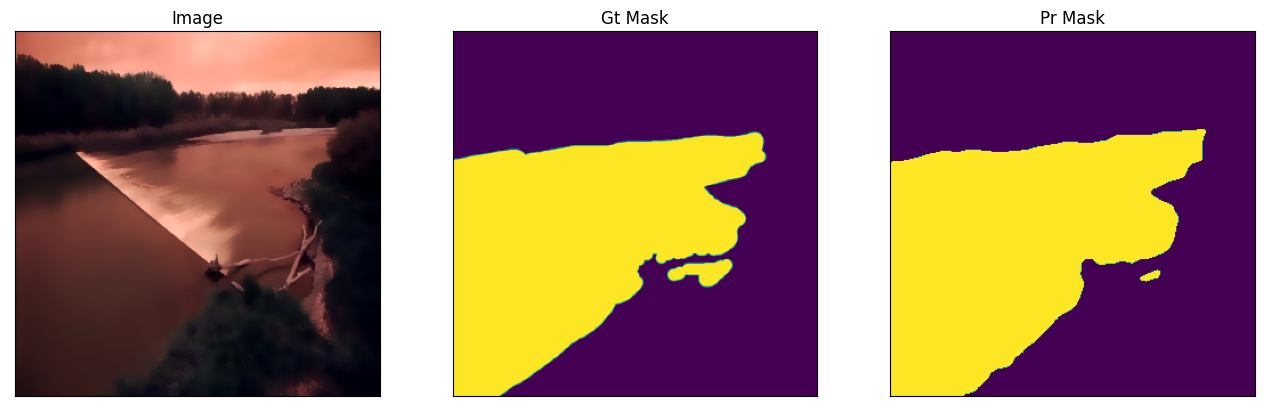

1/1 [==============================] - 0s 41ms/step


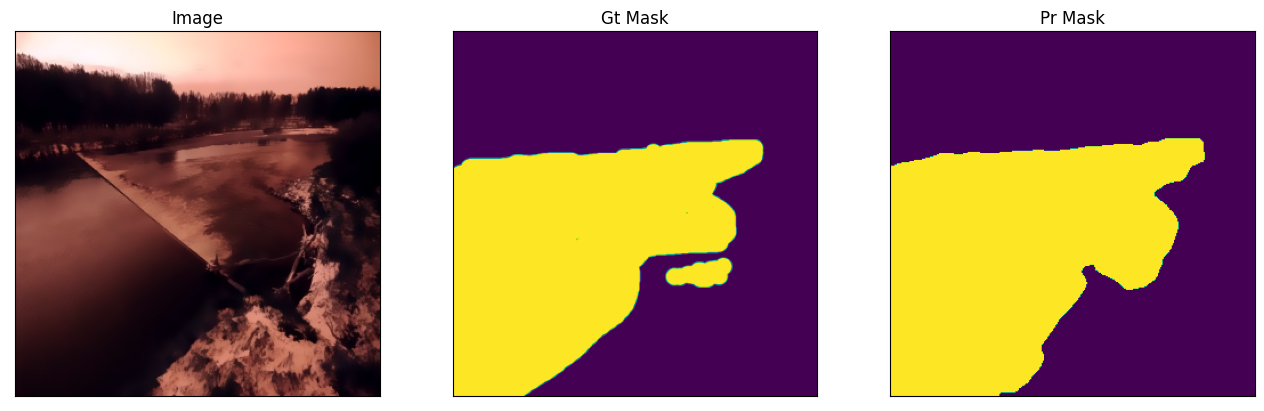

1/1 [==============================] - 0s 40ms/step


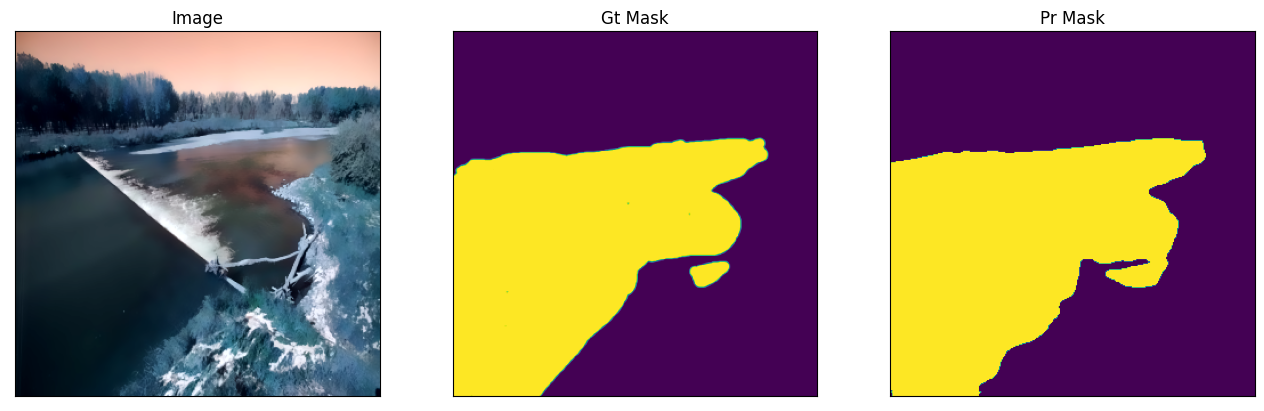

In [33]:
n = 10
#ids = np.random.choice(np.arange(len(test_h_dataset)), size=n)

for i in range(0, len(test_h_dataset)):
    
    image, gt_mask = test_h_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask.squeeze(),
        pr_mask=pr_mask.squeeze(),
    )